# Clustering 3K PBMCs with Adversarial Autoencoders

<img src="adversarial_autoencoder_model.png" width="800px" style="float:center" >

In [1]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import os

from utils import plot_results
from AAE import *

Using TensorFlow backend.


## Import dataset

In [2]:
!mkdir data
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz


mkdir: cannot create directory ‘data’: File exists
--2019-06-05 17:24:53--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 143.204.247.106, 143.204.247.13, 143.204.247.31, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|143.204.247.106|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621991 (7.3M) [application/x-tar]
Saving to: ‘data/pbmc3k_filtered_gene_bc_matrices.tar.gz’

data/pbmc3k_filtere 100%[===================>]   7.27M  --.-KB/s    in 0.04s   

2019-06-05 17:24:53 (176 MB/s) - ‘data/pbmc3k_filtered_gene_bc_matrices.tar.gz’ saved [7621991/7621991]



## Data preprocessing

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = './write/pbmc3k.h5ad'

scanpy==1.4.3 anndata==0.6.20 umap==0.3.9 numpy==1.15.4 scipy==1.2.0 pandas==0.24.2 scikit-learn==0.20.3 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [4]:
sc.settings.set_figure_params(dpi=80)

In [5]:
adata = sc.read_10x_mtx(
    './data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)                                # write a cache file for faster subsequent reading

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


In [6]:
adata.var_names_make_unique()  # this is unnecessary if using 'gene_ids'

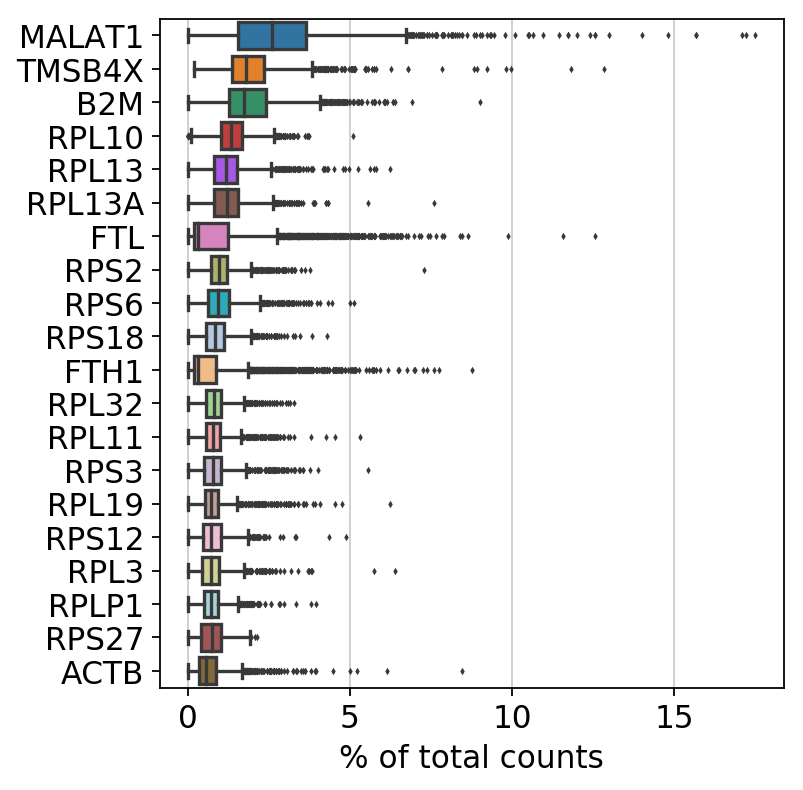

filtered out 19024 genes that are detected in less than 3 cells


In [7]:
# Show those genes that yield the highest fraction of counts in each single cells, across all cells.
sc.pl.highest_expr_genes(adata, n_top=20)

# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

adata = adata[adata.obs['n_genes'] < 2500, :]

In [8]:
# Data in log scale
sc.pp.log1p(adata)

In [9]:
adata.obs.shape

(2695, 1)

In [10]:
adata.obs.head()

n_genes
0                        
AAACATACAACCAC-1      781
AAACATTGAGCTAC-1     1352
AAACATTGATCAGC-1     1131
AAACCGTGCTTCCG-1      960
AAACCGTGTATGCG-1      522

In [11]:
adata.var.shape

(13714, 2)

In [12]:
adata.var.head()

gene_ids  n_cells
AL627309.1     ENSG00000237683        9
AP006222.2     ENSG00000228463        3
RP11-206L10.2  ENSG00000228327        5
RP11-206L10.9  ENSG00000237491        3
LINC00115      ENSG00000225880       18

In [13]:
adata.var_names

Index(['AL627309.1', 'AP006222.2', 'RP11-206L10.2', 'RP11-206L10.9',
       'LINC00115', 'NOC2L', 'KLHL17', 'PLEKHN1', 'RP11-54O7.17', 'HES4',
       ...
       'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB', 'AC145212.1',
       'AL592183.1', 'AL354822.1', 'PNRC2-1', 'SRSF10-1'],
      dtype='object', length=13714)

In [14]:
gene_names = adata.var_names.values

In [15]:
data = adata.X.toarray()

## Adversarial Autoencoder Model

### Network parameters

In [16]:
original_dim = data.shape[1]

layer_1_dim = 1000
layer_2_dim = 1000
batch_size = 100
latent_dim = 2
epochs = 20

In [17]:
encoder, decoder, discriminator, aae = build_AAE(original_dim, latent_dim, layer_1_dim, layer_2_dim)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Encoder Network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 13714)        0                                            
__________________________________________________________________________________________________
DO (Dropout)                    (None, 13714)        0           X[0][0]                          
__________________________________________________________________________________________________
H1 (Dense)                      (None, 1000)         13715000    DO[0][0]                         
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 1000)         4000        H1[0][0]                         
____________________________________________________________________________________________

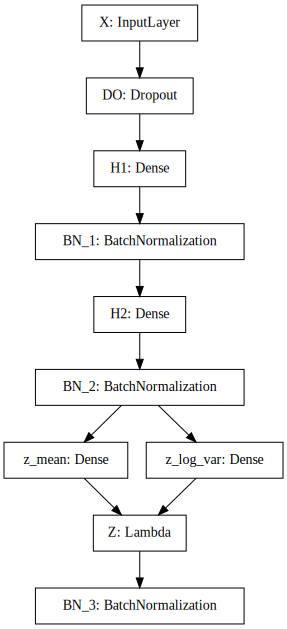

In [18]:
print("\nEncoder Network")
print("===============")
print(encoder.summary())
os.makedirs('img', exist_ok=True)
plot_model(encoder, to_file='img/aae_encoder.png', show_shapes=True)
SVG(model_to_dot(encoder).create(prog='dot', format='svg'))


Decoder Network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Z (InputLayer)               (None, 2)                 0         
_________________________________________________________________
H1 (Dense)                   (None, 1000)              3000      
_________________________________________________________________
H2 (Dense)                   (None, 1000)              1001000   
_________________________________________________________________
Xp (Dense)                   (None, 13714)             13727714  
Total params: 14,731,714
Trainable params: 14,731,714
Non-trainable params: 0
_________________________________________________________________
None


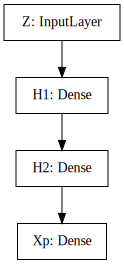

In [19]:
print("\nDecoder Network")
print("===============")
print(decoder.summary())
plot_model(decoder, to_file='img/aae_decoder.png', show_shapes=True)
SVG(model_to_dot(decoder).create(prog='dot', format='svg'))

In [20]:
print("\nAutoencoder Network")
print("===================")
aae.summary()
plot_model(aae, to_file='img/aae_autoencoder.png', show_shapes=True)
SVG(model_to_dot(aae).create(prog='dot', format='svg'))


Autoencoder Network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 13714)        0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 14728012    X[0][0]                          
__________________________________________________________________________________________________
decoder (Model)                 (None, 13714)        14731714    encoder[1][2]                    
__________________________________________________________________________________________________
discriminator (Model)           (None, 1)            1005001     encoder[1][2]                    
Total params: 30,464,727
Trainable params: 29,455,722
Non-trainable params: 1,009,005
__

In [21]:
print("\nDiscriminator Network")
print("=====================")
aae.summary()
plot_model(discriminator, to_file='img/aae_discriminator.png', show_shapes=True)
SVG(model_to_dot(discriminator).create(prog='dot', format='svg'))


Discriminator Network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 13714)        0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 14728012    X[0][0]                          
__________________________________________________________________________________________________
decoder (Model)                 (None, 13714)        14731714    encoder[1][2]                    
__________________________________________________________________________________________________
discriminator (Model)           (None, 1)            1005001     encoder[1][2]                    
Total params: 30,464,727
Trainable params: 29,455,722
Non-trainable params: 1,009,005


### Model training

In [22]:
discriminator_history, aae_history = train_AAE(aae, discriminator, encoder, data, batch_size, latent_dim, epochs)

# save model
os.makedirs('models', exist_ok=True)
aae.save('models/aae_autoencoder.h5')
encoder.save('models/aae_encoder.h5')
decoder.save('models/aae_decoder.h5')
discriminator.save('models/aee_discriminator.h5') 

Instructions for updating:
Use tf.cast instead.
Epoch 1/20, reconstruction loss: 0.230698, discriminator loss: 0.695226
Epoch 2/20, reconstruction loss: 0.064656, discriminator loss: 0.708018
Epoch 3/20, reconstruction loss: 0.050119, discriminator loss: 0.703164
Epoch 4/20, reconstruction loss: 0.049636, discriminator loss: 0.695158
Epoch 5/20, reconstruction loss: 0.046249, discriminator loss: 0.691443
Epoch 6/20, reconstruction loss: 0.047611, discriminator loss: 0.691153
Epoch 7/20, reconstruction loss: 0.045401, discriminator loss: 0.691531
Epoch 8/20, reconstruction loss: 0.044462, discriminator loss: 0.694910
Epoch 9/20, reconstruction loss: 0.048326, discriminator loss: 0.689760
Epoch 10/20, reconstruction loss: 0.044695, discriminator loss: 0.694610
Epoch 11/20, reconstruction loss: 0.047392, discriminator loss: 0.694398
Epoch 12/20, reconstruction loss: 0.046007, discriminator loss: 0.690983
Epoch 13/20, reconstruction loss: 0.045019, discriminator loss: 0.694010
Epoch 14/20,

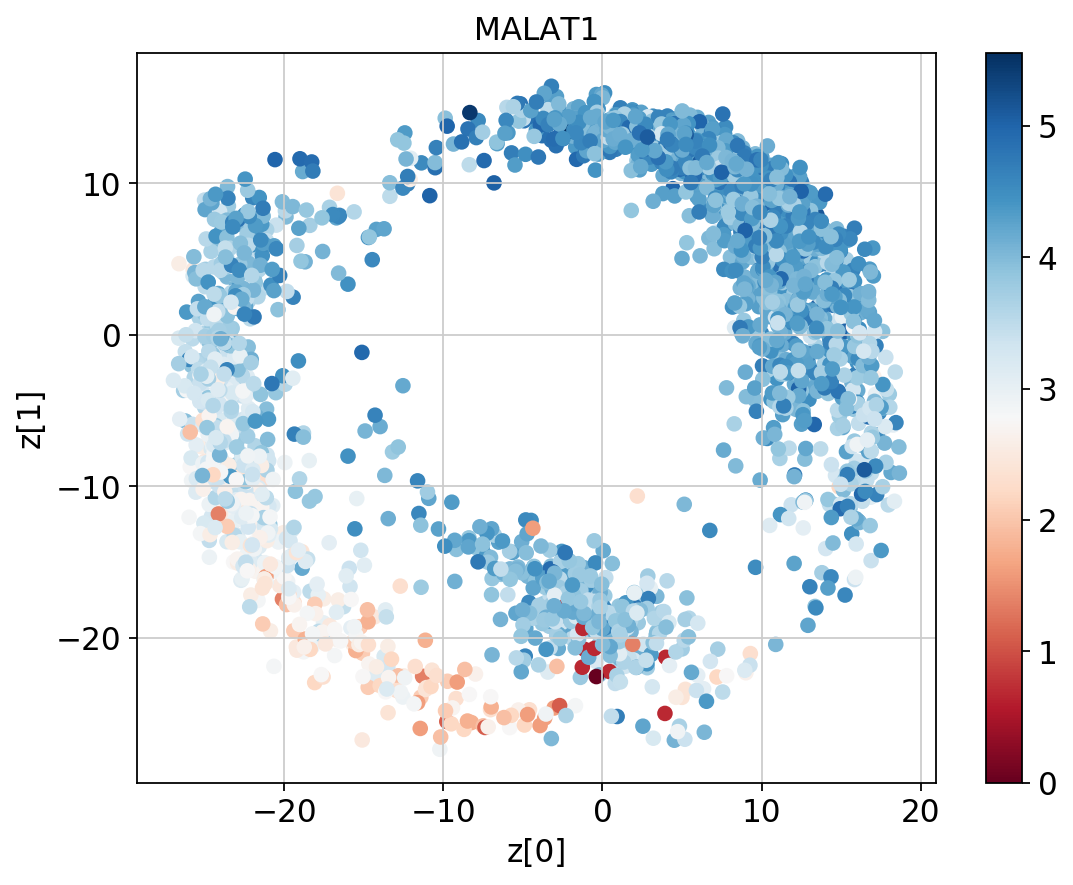

In [ ]:
models = (encoder, decoder)
gene_list = ['CST3', 'MALAT1', 'NKG7']
plot_results(models, data, gene_list, gene_names)